# 第5章 大規模言語モデルのファインチューニング

## 5.4 自然言語推論・意味的類似度計算・多肢選択式質問応答モデルの実装

### 5.4.3 多肢選択式質問応答

#### 環境の準備

In [ ]:
!pip install transformers[ja,torch] datasets matplotlib japanize-matplotlib

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 7.2/7.2 MB 74.9 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 486.2/486.2 kB 55.4 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 4.1/4.1 MB 89.1 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 268.8/268.8 kB 29.4 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 7.8/7.8 MB 16.8 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.3/1.3 MB 74.7 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 227.6/227.6 kB 27.0 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 599.9/599.9 kB 47.7 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 13.4/13.4 MB 50.3 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 47.4/47.4 MB 23.7 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
  Preparing metadata (setup.py) ... done
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━

In [ ]:
from transformers.trainer_utils import set_seed

# 乱数シードを42に固定
set_seed(42)

#### データセットの準備

In [ ]:
from pprint import pprint
from datasets import load_dataset

# Hugging Face Hub上のllm-book/JGLUEのリポジトリから
# JCommonsenseQAのデータを読み込む
train_dataset = load_dataset(
    "llm-book/JGLUE", name="JCommonsenseQA", split="train"
)
valid_dataset = load_dataset(
    "llm-book/JGLUE", name="JCommonsenseQA", split="validation"
)
# pprintで見やすく表示する
pprint(train_dataset[0])

Extracting data files:   0%|          | 0/2 [00:00<?, ?it/s]

Generating train split: 0 examples [00:00, ? examples/s]

Generating validation split: 0 examples [00:00, ? examples/s]

Dataset jglue downloaded and prepared to /root/.cache/huggingface/datasets/llm-book___jglue/JCommonsenseQA/1.1.0/afed02e914319785e72f3ea981b4bd3e00089f2361b1137820c183c6b8173edd. Subsequent calls will reuse this data.


{'choice0': '世界',
 'choice1': '写真集',
 'choice2': '絵本',
 'choice3': '論文',
 'choice4': '図鑑',
 'label': 2,
 'q_id': 0,
 'question': '主に子ども向けのもので、イラストのついた物語が書かれているものはどれ？'}


In [ ]:
pprint(train_dataset.features)

{'choice0': Value(dtype='string', id=None),
 'choice1': Value(dtype='string', id=None),
 'choice2': Value(dtype='string', id=None),
 'choice3': Value(dtype='string', id=None),
 'choice4': Value(dtype='string', id=None),
 'label': ClassLabel(names=['choice0',
                            'choice1',
                            'choice2',
                            'choice3',
                            'choice4'],
                     id=None),
 'q_id': Value(dtype='int64', id=None),
 'question': Value(dtype='string', id=None)}


#### トークナイザ

In [ ]:
from transformers import AutoTokenizer

# Hugging Face Hub上のモデル名を指定
model_name = "cl-tohoku/bert-base-japanese-v3"
# モデル名からトークナイザを読み込む
tokenizer = AutoTokenizer.from_pretrained(model_name)

#### データセット統計の可視化

100%|██████████| 8939/8939 [00:03<00:00, 2480.41it/s]


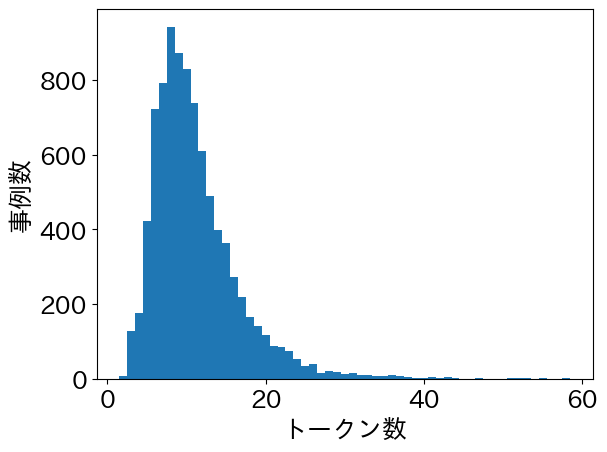

100%|██████████| 1119/1119 [00:00<00:00, 3075.89it/s]


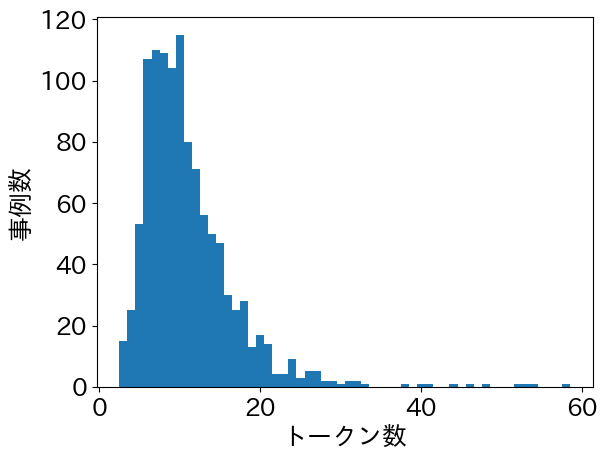

In [ ]:
from collections import Counter
import japanize_matplotlib
import matplotlib.pyplot as plt
from datasets import Dataset
from tqdm import tqdm

plt.rcParams["font.size"] = 18  # 文字サイズを大きくする

def visualize_question_length(dataset: Dataset):
    """データセット中の質問のトークン数の分布をグラフとして描画"""
    # データセット中の質問の長さを数える
    length_counter = Counter()
    for data in tqdm(dataset):
        length = len(tokenizer.tokenize(data["question"]))
        length_counter[length] += 1

    # length_counterの値から棒グラフを描画する
    plt.bar(length_counter.keys(), length_counter.values(), width=1.0)
    plt.xlabel("トークン数")
    plt.ylabel("事例数")
    plt.show()

visualize_question_length(train_dataset)
visualize_question_length(valid_dataset)

100%|██████████| 8939/8939 [00:06<00:00, 1459.85it/s]


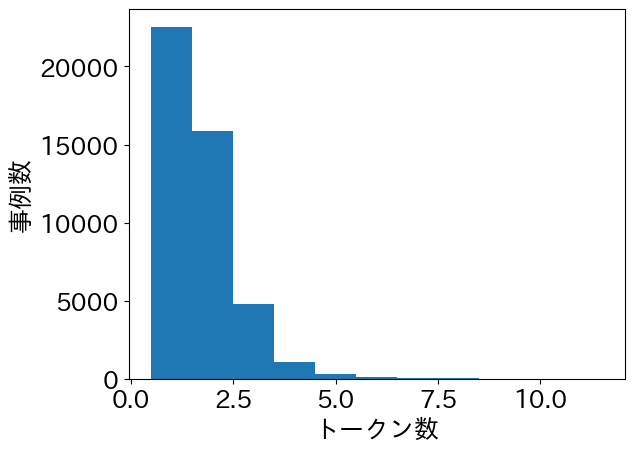

100%|██████████| 1119/1119 [00:00<00:00, 1591.58it/s]


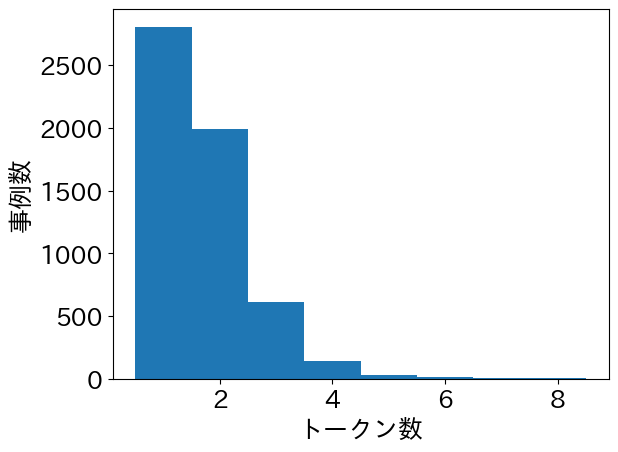

In [ ]:
def visualize_choice_length(dataset: Dataset):
    """データセット中の選択肢のトークン数の分布をグラフとして描画"""
    # データセット中の選択肢の長さを数える
    length_counter = Counter()
    for data in tqdm(dataset):
        for i in range(5):
            length = len(tokenizer.tokenize(data[f"choice{i}"]))
            length_counter[length] += 1

    # length_counterの値から棒グラフを描画する
    plt.bar(length_counter.keys(), length_counter.values(), width=1.0)
    plt.xlabel("トークン数")
    plt.ylabel("事例数")
    plt.show()

visualize_choice_length(train_dataset)
visualize_choice_length(valid_dataset)

#### データセットの前処理

In [ ]:
from transformers import BatchEncoding

def preprocess_multiple_choice(
    example: dict[str, str]
) -> BatchEncoding:
    """多肢選択式質問応答の事例をIDに変換"""
    # 選択肢の数を"choice"から始まるキーの数として算出
    num_choices = sum(
        key.startswith("choice") for key in example.keys()
    )

    # 質問と選択肢を連結してトークナイザーに渡す
    choice_list = [example[f"choice{i}"] for i in range(num_choices)]
    repeated_question_list = [example["question"]] * num_choices
    encoded_example = tokenizer(
        repeated_question_list, choice_list, max_length=64
    )

    # ラベルが入力に含まれている場合に、出力にも追加
    if "label" in example:
        encoded_example["labels"] = example["label"]
    return encoded_example

In [ ]:
from transformers import AutoTokenizer

example = train_dataset[0]
encoded_example = preprocess_multiple_choice(example)  # 事例の前処理
for choice in range(5):
    # IDから元の文字列を復元
    print(tokenizer.decode(encoded_example["input_ids"][choice]))

Truncation was not explicitly activated but `max_length` is provided a specific value, please use `truncation=True` to explicitly truncate examples to max length. Defaulting to 'longest_first' truncation strategy. If you encode pairs of sequences (GLUE-style) with the tokenizer you can select this strategy more precisely by providing a specific strategy to `truncation`.


[CLS] 主に 子ども 向け の もの で 、 イラスト の つい た 物語 が 書か れ て いる もの は どれ? [SEP] 世界 [SEP]
[CLS] 主に 子ども 向け の もの で 、 イラスト の つい た 物語 が 書か れ て いる もの は どれ? [SEP] 写真 集 [SEP]
[CLS] 主に 子ども 向け の もの で 、 イラスト の つい た 物語 が 書か れ て いる もの は どれ? [SEP] 絵本 [SEP]
[CLS] 主に 子ども 向け の もの で 、 イラスト の つい た 物語 が 書か れ て いる もの は どれ? [SEP] 論文 [SEP]
[CLS] 主に 子ども 向け の もの で 、 イラスト の つい た 物語 が 書か れ て いる もの は どれ? [SEP] 図鑑 [SEP]


In [ ]:
encoded_train_dataset = train_dataset.map(
    preprocess_multiple_choice,
    remove_columns=train_dataset.column_names,
)
encoded_valid_dataset = valid_dataset.map(
    preprocess_multiple_choice,
    remove_columns=valid_dataset.column_names,
)

Map:   0%|          | 0/8939 [00:00<?, ? examples/s]

Be aware, overflowing tokens are not returned for the setting you have chosen, i.e. sequence pairs with the 'longest_first' truncation strategy. So the returned list will always be empty even if some tokens have been removed.
Be aware, overflowing tokens are not returned for the setting you have chosen, i.e. sequence pairs with the 'longest_first' truncation strategy. So the returned list will always be empty even if some tokens have been removed.


Map:   0%|          | 0/1119 [00:00<?, ? examples/s]

Be aware, overflowing tokens are not returned for the setting you have chosen, i.e. sequence pairs with the 'longest_first' truncation strategy. So the returned list will always be empty even if some tokens have been removed.


In [ ]:
print(encoded_train_dataset[0])

{'input_ids': [[2, 13182, 16044, 12994, 464, 12518, 457, 384, 14930, 464, 12584, 449, 13360, 430, 14220, 494, 456, 12483, 12518, 465, 19382, 46, 3, 12575, 3], [2, 13182, 16044, 12994, 464, 12518, 457, 384, 14930, 464, 12584, 449, 13360, 430, 14220, 494, 456, 12483, 12518, 465, 19382, 46, 3, 13409, 6460, 3], [2, 13182, 16044, 12994, 464, 12518, 457, 384, 14930, 464, 12584, 449, 13360, 430, 14220, 494, 456, 12483, 12518, 465, 19382, 46, 3, 20647, 3], [2, 13182, 16044, 12994, 464, 12518, 457, 384, 14930, 464, 12584, 449, 13360, 430, 14220, 494, 456, 12483, 12518, 465, 19382, 46, 3, 15252, 3], [2, 13182, 16044, 12994, 464, 12518, 457, 384, 14930, 464, 12584, 449, 13360, 430, 14220, 494, 456, 12483, 12518, 465, 19382, 46, 3, 22929, 3]], 'token_type_ids': [[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 1], [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 1, 1], [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 1], [0, 0

#### ミニバッチ構築

In [ ]:
import torch
from transformers import BatchEncoding

def collate_fn_multiple_choice(
    features: list[BatchEncoding],
) -> dict[str, torch.Tensor]:
    """選択肢式質問応答の入力からミニバッチを構築"""
    # preprocess_multiple_choice関数に合わせてラベル名を"labels"とする
    label_name = "labels"

    batch_size = len(features)
    num_choices = len(features[0]["input_ids"])

    # 選択肢ごとの入力を一つのlistにまとめる
    flat_features = []
    for feature in features:
        flat_features += [
            {k: v[i] for k, v in feature.items() if k != label_name}
            for i in range(num_choices)
        ]

    # 選択肢ごとの入力についてパディングを行う
    flat_batch = tokenizer.pad(flat_features, return_tensors="pt")

    # 元のバッチごとに選択肢ごとの入力をまとめる
    # （バッチサイズ * 選択肢数, 最大系列長）の形をしたTensorを、
    # （バッチサイズ, 選択肢数, 最大系列長）に変換
    batch = {
        k: v.view(batch_size, num_choices, -1)
        for k, v in flat_batch.items()
    }

    # ラベルが入力に含まれている場合、バッチにまとめてTensorに変換
    if label_name in features[0]:
        labels = [feature[label_name] for feature in features]
        batch["labels"] = torch.tensor(labels, dtype=torch.int64)
    return batch

In [ ]:
batch_size = 4
encoded_examples = [
    preprocess_multiple_choice(train_dataset[i])
    for i in range(batch_size)
]
batch = collate_fn_multiple_choice(encoded_examples)
pprint({name: tensor.size() for name, tensor in batch.items()})

{'attention_mask': torch.Size([4, 5, 40]),
 'input_ids': torch.Size([4, 5, 40]),
 'labels': torch.Size([4]),
 'token_type_ids': torch.Size([4, 5, 40])}


#### モデルの準備

In [ ]:
from transformers import AutoModelForMultipleChoice

model = AutoModelForMultipleChoice.from_pretrained(
    model_name,
    num_labels=train_dataset.features["label"].num_classes,
)

# パラメータをメモリ上に隣接した形で配置
# これを実行しない場合、モデルの保存でエラーになることがある
for param in model.parameters():
    param.data = param.data.contiguous()

Some weights of the model checkpoint at cl-tohoku/bert-base-japanese-v3 were not used when initializing BertForMultipleChoice: ['cls.seq_relationship.bias', 'cls.predictions.decoder.bias', 'cls.predictions.transform.LayerNorm.bias', 'cls.predictions.transform.dense.bias', 'cls.predictions.transform.LayerNorm.weight', 'cls.predictions.bias', 'cls.predictions.transform.dense.weight', 'cls.seq_relationship.weight', 'cls.predictions.decoder.weight']
- This IS expected if you are initializing BertForMultipleChoice from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertForMultipleChoice from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
Some weights of BertForMultipleChoice were not initialized from the model

In [ ]:
model(**batch)

MultipleChoiceModelOutput(loss=tensor(1.4848, grad_fn=<NllLossBackward0>), logits=tensor([[-0.3795, -0.3648, -0.1021, -0.4802, -0.2815],
        [-0.0629,  0.0435, -0.4554, -0.1143, -0.2337],
        [-0.5503, -0.5156, -0.6268, -0.5746, -0.5088],
        [-0.4857, -0.4155, -0.5902, -0.2060, -0.2705]],
       grad_fn=<ViewBackward0>), hidden_states=None, attentions=None)

#### 訓練の実行

In [ ]:
from transformers import TrainingArguments

training_args = TrainingArguments(
    output_dir="output_jcommonsenseqa",  # 結果の保存フォルダ
    per_device_train_batch_size=32,  # 訓練時のバッチサイズ
    per_device_eval_batch_size=32,  # 評価時のバッチサイズ
    learning_rate=2e-5,  # 学習率
    lr_scheduler_type="linear",  # 学習率スケジューラの種類
    warmup_ratio=0.1,  # 学習率のウォームアップの長さを指定
    num_train_epochs=3,  # エポック数
    save_strategy="epoch",  # チェックポイントの保存タイミング
    logging_strategy="epoch",  # ロギングのタイミング
    evaluation_strategy="epoch",  # 検証セットによる評価のタイミング
    load_best_model_at_end=True,  # 訓練後に開発セットで最良のモデルをロード
    metric_for_best_model="accuracy",  # 最良のモデルを決定する評価指標
    fp16=True,  # 自動混合精度演算の有効化
    report_to="none",  # 外部ツールへのログを無効化
)

In [ ]:
import numpy as np

def compute_accuracy(
    eval_pred: tuple[np.ndarray, np.ndarray]
) -> dict[str, float]:
    """予測ラベルと正解ラベルから正解率を計算"""
    predictions, labels = eval_pred
    # predictionsは各ラベルについてのスコア
    # 最もスコアの高いインデックスを予測ラベルとする
    predictions = np.argmax(predictions, axis=1)
    return {"accuracy": (predictions == labels).mean()}

In [ ]:
from transformers import Trainer

trainer = Trainer(
    model=model,
    train_dataset=encoded_train_dataset,
    eval_dataset=encoded_valid_dataset,
    data_collator=collate_fn_multiple_choice,
    args=training_args,
    compute_metrics=compute_accuracy,
)
trainer.train()

/usr/local/lib/python3.10/dist-packages/transformers/optimization.py:411: FutureWarning: This implementation of AdamW is deprecated and will be removed in a future version. Use the PyTorch implementation torch.optim.AdamW instead, or set `no_deprecation_warning=True` to disable this warning
  warnings.warn(


Epoch,Training Loss,Validation Loss,Accuracy
1,0.772500,0.465534,0.825737
2,0.417200,0.443654,0.838248
3,0.280900,0.457295,0.840036


TrainOutput(global_step=840, training_loss=0.49020428430466423, metrics={'train_runtime': 260.8285, 'train_samples_per_second': 102.815, 'train_steps_per_second': 3.221, 'total_flos': 2305556727283980.0, 'train_loss': 0.49020428430466423, 'epoch': 3.0})

#### 訓練後のモデルの評価

In [ ]:
# 検証セットでモデルを評価
eval_metrics = trainer.evaluate(encoded_valid_dataset)
pprint(eval_metrics)

{'epoch': 3.0,
 'eval_accuracy': 0.8400357462019661,
 'eval_loss': 0.45729464292526245,
 'eval_runtime': 3.2555,
 'eval_samples_per_second': 343.724,
 'eval_steps_per_second': 10.751}


#### モデルの保存

Google Driveへの保存

In [ ]:
# Googleドライブをマウントする
from google.colab import drive

drive.mount("drive")

Mounted at drive


In [ ]:
# 保存されたモデルをGoogleドライブのフォルダにコピーする
!mkdir -p drive/MyDrive/llm-book
!cp -r output_jcommonsenseqa drive/MyDrive/llm-book

Hugging Face Hubへの保存

In [ ]:
from huggingface_hub import login

login()

# Hugging Face Hubのリポジトリ名
# "YOUR-ACCOUNT"は自らのユーザ名に置き換えてください
repo_name = "YOUR-ACCOUNT/bert-base-japanese-v3-output_jcommonsenseqa"
# トークナイザとモデルをアップロード
tokenizer.push_to_hub(repo_name)
model.push_to_hub(repo_name)